# Topology optimization using the SIMP method

This numerical tour investigates the optimal design of an elastic structure through a topology optimization approach. It consists in finding the optimal distribution of a material in a computational domain which minimizes the compliance (or, equivalently, maximizes the stiffness) of the resulting structure under a fixed volume fraction constraint.

For instance, in the bottom animation, the optimal material density (a continuous field $\theta(x)\in[0;1]$) of a cantilever beam evolves with the topoology optimization algorithm iterations. The first 20 iterations correspond to a "non-penalized" distribution where intermediate densities (i.e. $0<\theta(x)<1$) are allowed. However, such a *gray-level* distribution is hard to realize in practice and one would like to obtain a *black-and-white* design of material/void distribution. This is what is achieved in the last iterations where some penalty is applied to intermediate densities, exhibiting finally a truss-like design. Note that the final design is not a global optimum but only a local one. Hence, different designs can well be obtained if changing the initial conditions or the mesh density for instance.

![](cantilever_beam.gif "Title")

The present tour relies on one of the most widely implemented approach in topology optimization, namely the  Solid Isotropic Material with Penalisation (SIMP) method developed by Bendsoe and Sigmund [[BEN03]](#References). See also the monograph [[ALL07]](#References) and [Gregoire Allaire's class on *Optimal Design of Structures*](http://www.cmap.polytechnique.fr/~MAP562/index.php) at Ecole Polytechnique. In particular, this tour refers to [lesson 8](http://www.cmap.polytechnique.fr/~MAP562/archives/slides/lesson8.pdf) and is the direct adaptation of the [SIMP Topology Optimization example](http://www.cmap.polytechnique.fr/%7Eallaire/map562/console.simp.edp) of the [CMAP group toolbox written in Freefem++](http://www.cmap.polytechnique.fr/~allaire/freefem.html).

This tour should also work in parallel.

## Theory

### Compliance optimization on binary shapes

Let us consider a computational domain $D$ in which we seek an elastic material domain $\Omega$ ($D\setminus\Omega$ representing void) so that the compliance under prescribed loading is minimal when subjected to a fixed volume constraint $\text{Vol}(\Omega) = \eta \text{Vol}(D)$. Replacing the shape $\Omega$ by its characteristic function $\chi(x)\in \{0,1\}$, the previous problem can be formulated as the following optimization problem:

$$\begin{array}{rl}\displaystyle{\min_{\chi}} & \displaystyle{\int_D \boldsymbol{f}\cdot\boldsymbol{u}(\chi) \text{ dx}+\int_{\Gamma_N} \boldsymbol{T}\cdot\boldsymbol{u}(\chi)\text{ dS}}\\
\text{s.t.} & \int_D \chi(x) \text{ dx} = \eta \text{Vol}(D) \\
& \chi(x)\in \{0,1\}
\end{array}$$

where $\boldsymbol{u}(\chi)$ is the solution of the following $\chi(x)-$dependent elasticity problem:

$$\begin{align}
\text{div}\, \boldsymbol{\sigma} + \boldsymbol{f}=0 &\quad\text{in } D\\
\boldsymbol{\sigma} = \chi(x)\mathbb{C}:\nabla^s \boldsymbol{u} &\quad\text{in } D\\
\boldsymbol{\sigma}\cdot\boldsymbol{n} = \boldsymbol{T} &\quad\text{on }\Gamma_N \\
\boldsymbol{u} = 0 &\quad\text{on }\Gamma_D 
\end{align}$$

where $\boldsymbol{f}$ is a body force, $\boldsymbol{T}$ corresponds to surface tractions on $\Gamma_N$ and $\mathbb{C}$ is the elastic material stiffness tensor. Owing to the elastic nature of the problem, the compliance can also be expressed using the elastic stress energy density:

$$\int_D \boldsymbol{f}\cdot\boldsymbol{u}(\chi) \text{ dx}+\int_{\Gamma_N} \boldsymbol{T}\cdot\boldsymbol{u}(\chi)\text{ dS}=\int_D \boldsymbol{\sigma}(\chi):(\chi(x)\mathbb{C})^{-1}:\boldsymbol{\sigma}(\chi)\text{ dx}=\int_D \nabla^s \boldsymbol{u}(\chi):(\chi(x)\mathbb{C}):\nabla^s \boldsymbol{u}(\chi)\text{ dx}
$$

so that the above optimization problem can be reformulated as:

$$\begin{array}{rl}\displaystyle{\min_{\chi,\boldsymbol{u}}} & \displaystyle{\int_D \boldsymbol{\sigma}(\chi):(\chi(x)\mathbb{C})^{-1}:\boldsymbol{\sigma}(\chi)\text{ dx}}\\
\text{s.t.} & \text{div}\, \boldsymbol{\sigma} + \boldsymbol{f}=0 \quad\text{in } D\\
& \boldsymbol{\sigma}\cdot\boldsymbol{n} = \boldsymbol{T} \quad\text{on }\Gamma_N \\
& \int_D \chi(x) \text{ dx} = \eta \text{Vol}(D) \\
& \chi(x)\in \{0,1\}
\end{array}$$

### Continuous relaxation and SIMP penalization

The binary constraint $\chi(x)\in \{0,1\}$ makes the above problem extremely difficult to solve so that a classical remedy consists in relaxing the constraint by a continuous constraint $\theta(x)\in [0,1]$ where $\theta(x)$ will approximate the characteristic function $\chi(x)$ by a gray-level continuous function taking values between 0 and 1.

However, in order to still obtain a final binary density distribution, the binary modulus $\chi(x)\mathbb{C}$ will be replaced by $\theta(x)^p \mathbb{C}$ with $p>1$ in order to penalize intermediate densities, yielding the so-called *SIMP formulation*:

$$\begin{array}{rl}\displaystyle{\min_{\theta,\boldsymbol{\sigma}} J_p(\theta,\boldsymbol{\sigma})=\min_{\theta,\boldsymbol{\sigma}}} & \displaystyle{ \int_D \boldsymbol{\sigma}:(\theta(x)^{-p}\mathbb{C}^{-1}):\boldsymbol{\sigma}\text{ dx}}\\
\text{s.t.} & \text{div}\, \boldsymbol{\sigma} + \boldsymbol{f}=0 \quad\text{in } D\\
& \boldsymbol{\sigma}\cdot\boldsymbol{n} = \boldsymbol{T} \quad\text{on }\Gamma_N \\
& \int_D \theta(x) \text{ dx} = \eta \text{Vol}(D) \\
& 0 \leq \theta(x) \leq 1
\end{array}$$

### Optimization of the SIMP formulation

Unfortunately jointly minimizing $J_p$ over $(\theta,\boldsymbol{\sigma})$ is hard to do in practice since this functional is non-convex (except if $p=1$). However, it is convex over each variable $\theta$ and $\boldsymbol{\sigma}$ when fixing the other variable. This makes alternate minimization an attractive method for finding a local optimum. Besides, minimizing directly for a fixed value of $p>1$ does not work well in practice. A better solution consists in performing alternate minimization steps and progressively increase $p$ from 1 to a maximum value (typically 3 or 4) using some heuristic (see later).

Iteration $n+1$ of the algorithm, knowing a previous pair $(\theta_n,\boldsymbol{\sigma}_n)$ and a given value of the penalty exponent $p_{n}$, therefore consists in:

* minimizing $J_{p_n}(\theta_n,\boldsymbol{\sigma})$ yielding $\boldsymbol{\sigma}_{n+1}=(\theta_n)^{p_n}\mathbb{C}:\nabla^s\boldsymbol{u}_{n+1}$
* minimizing $J_{p_n}(\theta, \boldsymbol{\sigma}_{n+1})$ yielding $\theta_{n+1}$
* potentially update the value of the exponent using some heuristic $p_n \to p_{n+1}$

Both minimization problems are quite easy to solve since the first one is nothing else than a heterogeneous elastic problem with some known modulus $(\theta_n(x))^{p_n}\mathbb{C}$.

The second problem can be rewritten using the Lagrange multiplier $\lambda$ corresponding to the toal volume constraint, as follows:

$$\begin{equation*}
\min_{\theta\in[0;1]} \: \int_D \theta(x)^{-p_n}e(\boldsymbol{\sigma}_{n+1})\text{ dx} + \lambda \left( \int_D \theta(x) \text{ dx} -\eta \text{Vol}(D)\right)
\end{equation*}$$

where $e(\sigma_{n+1}) = \boldsymbol{\sigma}_{n+1}:\mathbb{C}^{-1}:\boldsymbol{\sigma}_{n+1}= (\theta_n)^{p_n} \boldsymbol{\sigma}_{n+1}:\nabla^s \boldsymbol{u}_{n+1}$. The optimality conditions for this problem yields the following explicit and local condition:

$$\begin{equation*}
-p_n \theta_{n+1}^{-p_n-1} e(\sigma_{n+1}) + \lambda = 0
\end{equation*}$$

which along with the $[\theta_{min};1]$ constraint gives:

$$\begin{equation*}
\theta_{n+1} = \min \left\lbrace 1; \max \left\lbrace \theta_{min}; \left(\frac{p_n e(\sigma_{n+1})}{\lambda}\right)^{1/(p_n+1)} \right\rbrace\right\rbrace
\end{equation*}$$

where we replaced the $0$ constraint by a minimum density value $\theta_{min}>0$ to avoid degeneracy issue with void material.

Note that the above expression assumes that $\lambda$ is known. Its value is found by satsifying the volume constraint $\int_D \theta(x) \text{ dx} =\eta \text{Vol}(D)$.

## FEniCS implementation

We first define some parameters of the algorithm. The most important ones concern the number of total alternate minimizations (AM) `niter` and the parameters controlling the exponent update strategy:

* `niternp` corresponds to the number of first (AM) for which $p=1$. These are non-penalized iterations yielding a diffuse gray-level field $\theta(x)$ at convergence (note that we solve this convex problem with AM iterations although one could use a dedicated convex optimization solver).
* `pmax` is the maximum value taken by the penalty exponent $p$
* `exponent_update_frequency` corresponds to the minimum number of AM iterations between two consecutive updates of the exponent

In [14]:
%matplotlib inline
from dolfin import *
import matplotlib.pyplot as plt
import numpy as np

# Algorithmic parameters
niternp = 20 # number of non-penalized iterations
niter = 80 # total number of iterations
pmax = 4        # maximum SIMP exponent
exponent_update_frequency = 4 # minimum number of steps between exponent update
tol_mass = 1e-4 # tolerance on mass when finding Lagrange multiplier
thetamin = 0.001 # minimum density modeling void

We now define the problem parameters, in particular the target material density $(\eta=40\%$ here). The mesh consists of a rectangle of dimension $4\times 1$, clamped on its left side and loaded by a uniformly distributed vertical force on a line of length 0.1 centered around the center of the right side.

Finally, we initialized the SIMP penalty exponent to $p=1$ and initialized also the density field and the Lagrange multiplier $\lambda$.

In [15]:
# Problem parameters
thetamoy = 0.4 # target average material density
E = Constant(1)
nu = Constant(0.3)
lamda = E*nu/(1+nu)/(1-2*nu)
mu = E/(2*(1+nu))
f = Constant((0, -1)) # vertical downwards force

# Mesh
mesh = RectangleMesh(Point(-2, 0), Point(2, 1), 50, 30, "crossed")
# Boundaries
def left(x, on_boundary):
    return near(x[0], -2) and on_boundary
def load(x, on_boundary):
    return near(x[0], 2) and near(x[1], 0.5, 0.05)
facets = MeshFunction("size_t", mesh, 1)
AutoSubDomain(load).mark(facets, 1)
ds = Measure("ds", subdomain_data=facets)

# Function space for density field
V0 = FunctionSpace(mesh, "DG", 0)
# Function space for displacement
V2 = VectorFunctionSpace(mesh, "CG", 2)
# Fixed boundary condtions
bc = DirichletBC(V2, Constant((0, 0)), left)

p = Constant(1) # SIMP penalty exponent
exponent_counter = 0 # exponent update counter
lagrange = Constant(1) # Lagrange multiplier for volume constraint

thetaold = Function(V0, name="Density")
thetaold.interpolate(Constant(thetamoy))
coeff = thetaold**p
theta = Function(V0)

volume = assemble(Constant(1.)*dx(domain=mesh))
avg_density_0 = assemble(thetaold*dx)/volume # initial average density
avg_density = 0.

We now define some useful functions for formulating the linear elastic variational problem.

In [16]:
def eps(v):
    return sym(grad(v))
def sigma(v):
    return coeff*(lamda*div(v)*Identity(2)+2*mu*eps(v))
def energy_density(u, v):
    return inner(sigma(u), eps(v))

# Inhomogeneous elastic variational problem
u_ = TestFunction(V2)
du = TrialFunction(V2)
a = inner(sigma(u_), eps(du))*dx
L = dot(f, u_)*ds(1)

In [17]:
def local_project(v, V):
    dv = TrialFunction(V)
    v_ = TestFunction(V)
    a_proj = inner(dv, v_)*dx
    b_proj = inner(v, v_)*dx
    solver = LocalSolver(a_proj, b_proj)
    solver.factorize()
    u = Function(V)
    solver.solve_local_rhs(u)
    return u
def update_theta():
    theta.assign(local_project((p*coeff*energy_density(u, u)/lagrange)**(1/(p+1)), V0))
    thetav = theta.vector().get_local()
    theta.vector().set_local(np.maximum(np.minimum(1, thetav), thetamin))
    theta.vector().apply("insert")
    avg_density = assemble(theta*dx)/volume
    return avg_density

We now define a function for finding the correct value of the Lagrange multiplier $\lambda$. First, a rough bracketing of $\lambda$ is obtained, then a dichotomy is performed in the interval `[lagmin,lagmax]` until the correct average density is obtained to a certain tolerance.

In [18]:
def update_lagrange_multiplier(avg_density):
    avg_density1 = avg_density
    # Initial bracketing of Lagrange multiplier
    if (avg_density1 < avg_density_0):
        lagmin = float(lagrange)
        while (avg_density < avg_density_0):
            lagrange.assign(Constant(lagrange/2))
            avg_density = update_theta()
        lagmax = float(lagrange)
    elif (avg_density1 > avg_density_0):
        lagmax = float(lagrange)
        while (avg_density > avg_density_0):
            lagrange.assign(Constant(lagrange*2))
            avg_density = update_theta()
        lagmin = float(lagrange)
    else:
        lagmin = float(lagrange)
        lagmax = float(lagrange)

    # Dichotomy on Lagrange multiplier
    inddico=0
    while ((abs(1.-avg_density/avg_density_0)) > tol_mass):
        lagrange.assign(Constant((lagmax+lagmin)/2))
        avg_density = update_theta()
        inddico += 1;
        if (avg_density < avg_density_0):
            lagmin = float(lagrange)
        else:
            lagmax = float(lagrange)
    print("   Dichotomy iterations:", inddico)


Finally, the exponent update strategy is implemented:

* first, $p=1$ for the first `niternp` iterations
* then, $p$ is increased by some amount which depends on the average gray level of the density field computed as $g = \frac{1}{\text{Vol(D)}}\int_D 4(\theta-\theta_{min})(1-\theta)\text{ dx}$, that is $g=0$ is $\theta(x)=\theta_{min}$ or $1$ everywhere and $g=1$ is $\theta=(\theta_{min}+1)/2$ everywhere.
* Note that $p$ can increase only if at least `exponent_update_frequency` AM iterations have been performed since the last update and only if the compliance evolution falls below a certain threshold.

In [19]:
def update_exponent(exponent_counter):
    exponent_counter += 1
    if (i < niternp):
        p.assign(Constant(1))
    elif (i >= niternp):
        if i == niternp:
            print("\n Starting penalized iterations\n")
        if ((abs(compliance-old_compliance) < 0.01*compliance_history[0]) and 
            (exponent_counter > exponent_update_frequency) ):
            # average gray level
            gray_level = assemble((theta-thetamin)*(1.-theta)*dx)*4/volume
            p.assign(Constant(min(float(p)*(1+0.3**(1.+gray_level/2)), pmax)))
            exponent_counter = 0
            print("   Updated SIMP exponent p = ", float(p))
    return exponent_counter


Finally, the global loop for the algorithm is implemented consisting, at each iteration, of the elasticity problem resolution, the corresponding compliance computation, the update for $\theta$ and its associated Lagrange multiplier $\lambda$ and the exponent update procedure.

In [20]:
u = Function(V2, name="Displacement")
old_compliance = 1e30
ffile = XDMFFile("topology_optimization.xdmf")
ffile.parameters["flush_output"]=True
ffile.parameters["functions_share_mesh"]=True
compliance_history = []
for i in range(niter):
    solve(a == L, u, bc, solver_parameters={"linear_solver": "cg", "preconditioner": "hypre_amg"})
    ffile.write(thetaold, i)
    ffile.write(u, i)

    compliance = assemble(action(L, u))
    compliance_history.append(compliance)
    print("Iteration {}: compliance =".format(i), compliance)

    avg_density = update_theta()

    update_lagrange_multiplier(avg_density)

    exponent_counter = update_exponent(exponent_counter)

    # Update theta field and compliance
    thetaold.assign(theta)
    old_compliance = compliance

Solving linear variational problem.
Iteration 0: compliance = 2.7144075331192656
   Dichotomy iterations: 11
Solving linear variational problem.
Iteration 1: compliance = 1.6680906028612568
   Dichotomy iterations: 9
Solving linear variational problem.
Iteration 2: compliance = 1.58339452358641
   Dichotomy iterations: 8
Solving linear variational problem.
Iteration 3: compliance = 1.5653282243671938
   Dichotomy iterations: 10
Solving linear variational problem.
Iteration 4: compliance = 1.5590374580516773
   Dichotomy iterations: 7
Solving linear variational problem.
Iteration 5: compliance = 1.5561206377803654
   Dichotomy iterations: 10
Solving linear variational problem.
Iteration 6: compliance = 1.5545325271475088
   Dichotomy iterations: 7
Solving linear variational problem.
Iteration 7: compliance = 1.5535964366313237
   Dichotomy iterations: 8
Solving linear variational problem.
Iteration 8: compliance = 1.5528773407369745
   Dichotomy iterations: 10
Solving linear variational

The final density is represented as well as the convergence history of the compliance. One can note that the final compliance obtained after the first non-penalized iterations is smaller than the final one. This initially obtained topology is therefore more optimal than the final one, although it is made of large diffuse gray regions (see XMDF outputs or the animation at the beginning of the tour) contrary to the final one which is close to being binary.

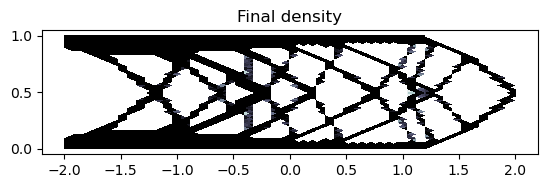

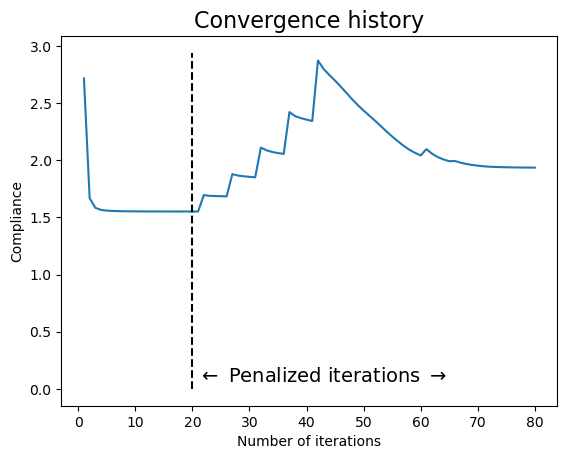

In [21]:
plot(theta, cmap="bone_r")
plt.title("Final density")

plt.figure()
plt.plot(np.arange(1, niter+1), compliance_history)
ax = plt.gca()
ymax = ax.get_ylim()[1]
plt.plot([niternp, niternp], [0, ymax], "--k")
plt.annotate(r"$\leftarrow$ Penalized iterations $\rightarrow$", xy=[niternp+1, ymax*0.02], fontsize=14)
plt.xlabel("Number of iterations")
plt.ylabel("Compliance")
plt.title("Convergence history", fontsize=16)
plt.show()

## References

[ALL07]: Allaire, Grégoire, and Marc Schoenauer. *Conception optimale de structures.* Vol. 58. Berlin: Springer, 2007.

[BEN03]: Bendsoe, Martin Philip and Sigmund, Ole. *Topology Optimization: Theory, Methods, and Applications*. Springer Science & Business Media, 2003.